# Вычисление атомных орбиталей водорода

In [2]:
import prody as prd
import numpy as np
from IPython.display import display,Image
import psi4

In [3]:
import numpy
import scipy.special
import scipy.misc

In [4]:
import npy2cube

Задача этого практикума - расчитать электронные орбитали атома водорода. Для начала сделаем это с использованием известного решения уравнения Шрёдингера, где радиальная часть волновой функции выражается через полиномы Лагерра, а угловая зависимость через сферические функции. В итоге будем для каждой точки пространства получать квадрат модуля волновой функции - плотность вероятности обнаружить там электрон, если для него известны квантовые числа n,l,m, то есть определены энергия, квадрат момента импульса и проекция момента импульса на ось z.

Ниже приведена формула для зависимости волновой функции от сферических координат при заданных n,l,m

<img src="./c4bd133ca21b058cd63cf41ba08333e3f2f6a096.svg"/>

In [4]:
#Функция расчёта плотности вероятности с заданными n,l,m
def w(n,l,m,d):
    
    x,y,z = numpy.mgrid[-d:d:50j,-d:d:50j,-d:d:50j]
    
    #расстояние до электрона
    r = lambda x,y,z: numpy.sqrt(x**2+y**2+z**2)
    #зенитный угол электрона
    theta = lambda x,y,z: numpy.arccos(z/r(x,y,z))
    #азимутальный угол электрона
    phi = lambda x,y,z: numpy.arctan(y/x)
    
    a0 = 1.
    
    #расчёт радиальной волновой функции
    R = lambda r,n,l: np.sqrt(np.math.factorial(n-l-1)/(2*n*np.math.factorial(n+l))) * (2/(n*a0))**1.5 *(2*r/n/a0)**l * numpy.exp(-r/n/a0) * scipy.special.genlaguerre(n-l-1,2*l+1)(2*r/n/a0)
    #расчёт полной волново функции
    WF = lambda r,theta,phi,n,l,m: R(r,n,l) * scipy.special.sph_harm(m,l,phi,theta)
    #расчёт плотности вероятности из волновой функции
    absWF = lambda r,theta,phi,n,l,m: numpy.absolute(WF(r,theta,phi,n,l,m))**2

    return absWF(r(x,y,z),theta(x,y,z),phi(x,y,z),n,l,m)

In [5]:
#Применим нашу функцияю к первым трём энергетическим уровням атома водорода, т.е. n=1,2,3
for n in range(0,4):
    d=20
    step=30/49
    for l in range(0,n):
        for m in range(0,l+1,1):
            grid=(w(n,l,m,d))
            name='%s-%s-%s' % (n,l,m)
            
            npy2cube.npy2cube(grid,(-d,-d,-d),(step,step,step),name+'.cube')

Визуализируем одно из решений с помощью py3Dmol

In [5]:
import py3Dmol
view = py3Dmol.view()
alpha = open('3-1-0.cube','r').read()
view.addVolumetricData(alpha, "cube", {'isoval': 0.00005, 'color': "red", 'opacity': 10})
view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Далее все решения я визуализировал в виде поверхностей одинаковой плотности вероятности на своём паймоле. Здесь приведу картики

n=1,l=0,m=0


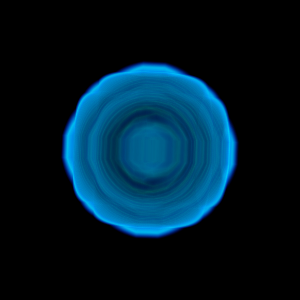

n=2,l=0,m=0


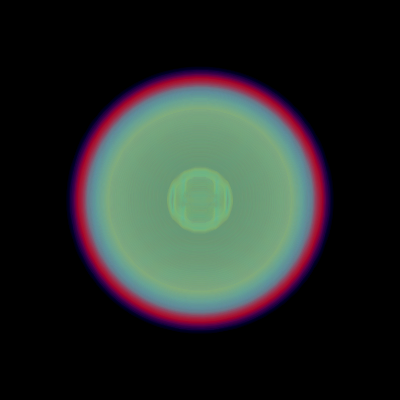

n=2,l=1,m=0


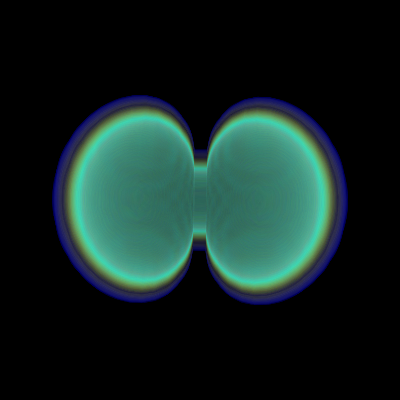

n=2,l=1,m=1


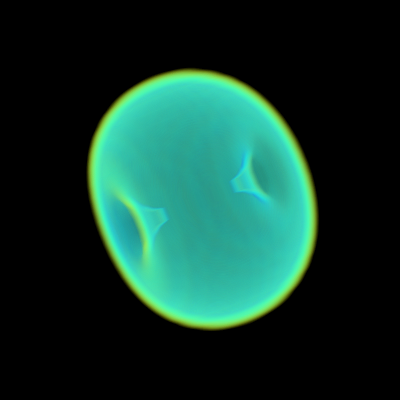

n=3,l=0,m=0


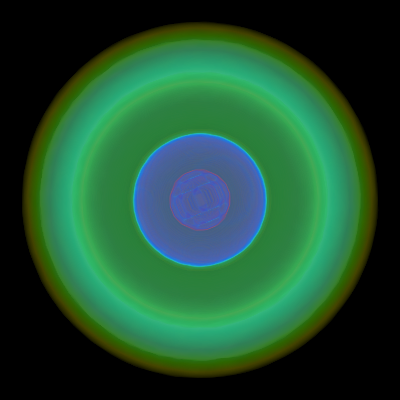

In [6]:
print('n=1,l=0,m=0')
display(Image('./1_0_0.png',width=300))
print('n=2,l=0,m=0')
display(Image('./2_0_0.png',width=300))
print('n=2,l=1,m=0')
display(Image('./2_1_0.png',width=300))
print('n=2,l=1,m=1')
display(Image('./2_1_1.png',width=300))
print('n=3,l=0,m=0')
display(Image('./3_0_0.png',width=300))

n=3,l=1,m=0


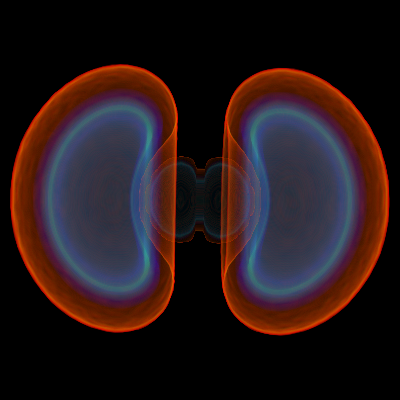

n=3,l=1,m=1


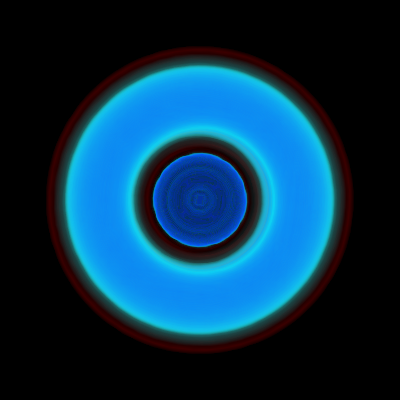

n=3,l=2,m=0


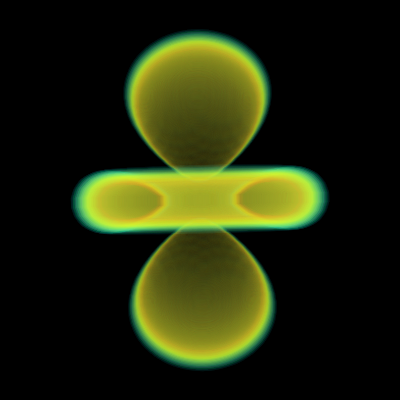

n=3,l=2,m=1


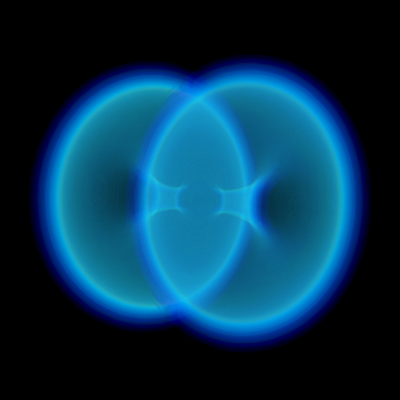

n=3,l=2,m=2


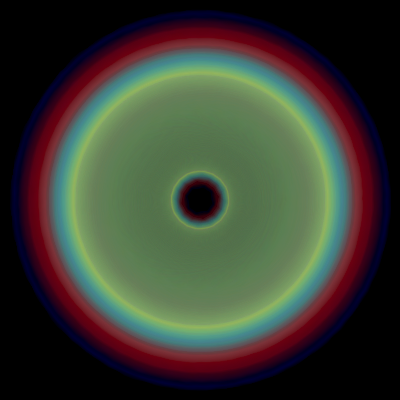

In [24]:
print('n=3,l=1,m=0')
display(Image('./3_1_0.png',width=300))
print('n=3,l=1,m=1')
display(Image('./3_1_1.png',width=300))
print('n=3,l=2,m=0')
display(Image('./3_2_0.png',width=300))
print('n=3,l=2,m=1')
display(Image('./3_2_1.png',width=300))
print('n=3,l=2,m=2')
display(Image('./3_2_2.png',width=300))

Итого мы получили распределение электронной плотности в пространстве для разных возможных комбинаций n,l,m, полученное непосредственно из решения уравнения Шрёдингера. Теперь воспользуемся специальным квантовохимическим пакетом psi4.

In [10]:
psi4.core.set_output_file('output.dat')

Зададим строение нашей молекулы:

In [11]:
g = '''
H
'''

Расчитаем энергию системы и волновую функцию для основного энергетического состояния, а также волновые функции для первых возбуждённых состояний. По умолчанию psi4 использует в расчётах метод ограниченного Хартри-Фока (RHF), который подходит только для систем с чётным числом электронов. Поскольку в нашей системе всего один электрон, будем использовать ROHF.

In [12]:
m = psi4.geometry(g)
psi4.set_options({"maxiter": 200, "fail_on_maxiter" :  True, 'reference':'rohf'})
ener,wfn=psi4.energy('scf/cc-pvtz',return_wfn=True, molecule = m )

Энергия системы: -0.4998098113018423

In [13]:
psi4.cubeprop(wfn)

Далее визуализируем полученные решения

1s


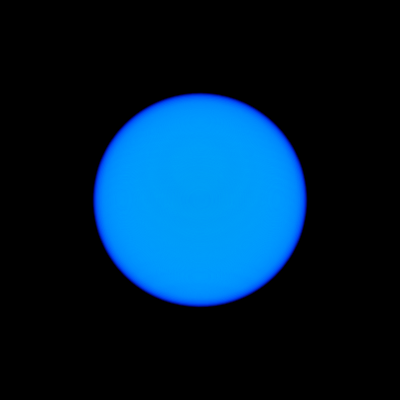

2s


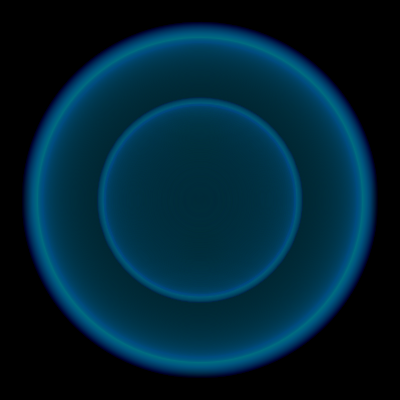

2pz


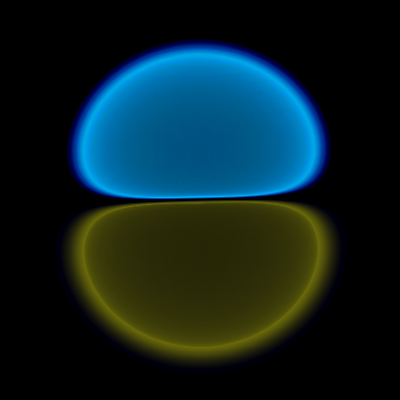

2px


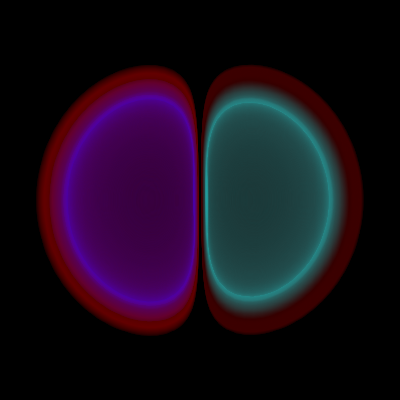

3s


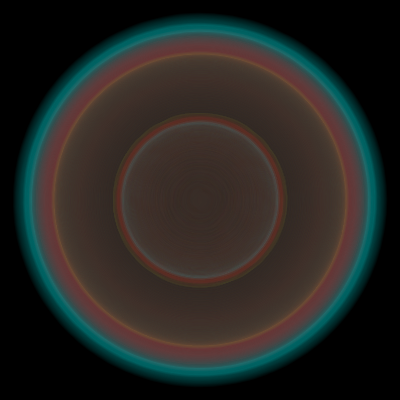

In [8]:
print('1s')
display(Image('./1_s.png',width=300))
print('2s')
display(Image('./2_s.png',width=300))
print('2pz')
display(Image('./2_p_z.png',width=300))
print('2px')
display(Image('./2_p_x.png',width=300))
print('3s')
display(Image('./3_s.png',width=300))

3pz


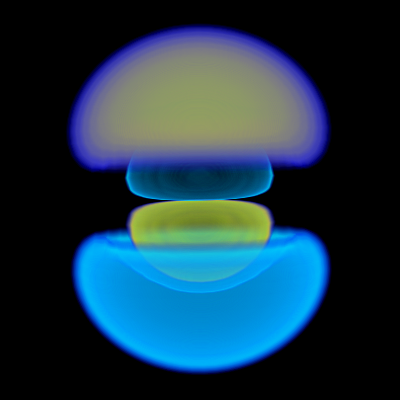

3px


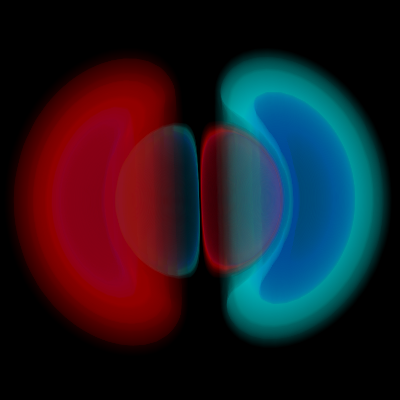

3dz^2


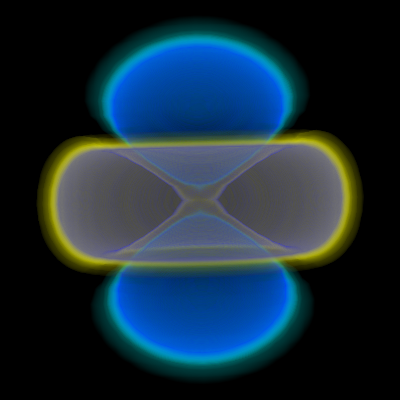

3dxz


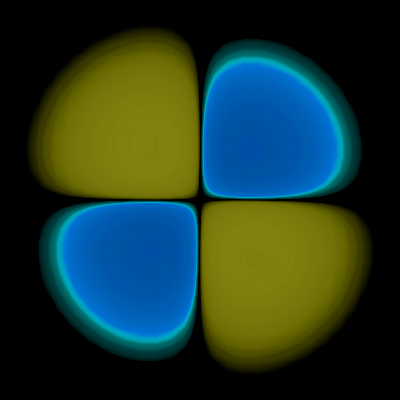

3dxy


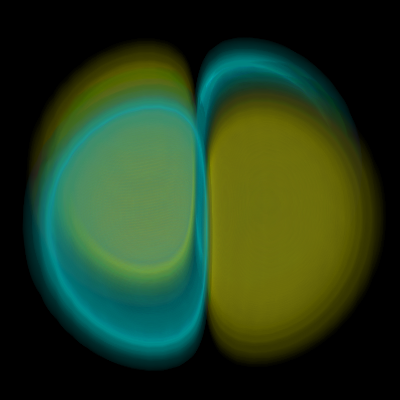

In [7]:
print('3pz')
display(Image('./3_p_z.png',width=300))
print('3px')
display(Image('./3_p_x.png',width=300))
print('3dz^2')
display(Image('./3_d_z^2.png',width=300))
print('3dxz')
display(Image('./3_d_xz.png',width=300))
print('3dxy')
display(Image('./3_d_xy.png',width=300))

Мы видим, что наши решения совпадают с только что полученными при m=0, однако начинают различаться при m отличных от нуля. Это связано с тем, что psi4 выдаёт не собственные функции оператора проекции момента импульса, а их суперпозиции. При сложении или вычитании фунции в виде торов, содержащие комплексную экспоненту с разными знаками, превращаются в вещественные функции с изоповерхностями в форме гантельки для p-орбиталей или лепестков для d-орбиталей.